## Setup

In [1]:
!pip install shap
!pip install --upgrade xlrd
!pip install imbalanced-learn

In [2]:
# utilities
import os
import pandas as pd 
import numpy as np
import math
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm 
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

import warnings
from IPython.display import clear_output 
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Download

In [78]:
mode = 'ATP'
data_dir = 'Womens'

In [90]:
%cd ..

/content


In [91]:
!mkdir data
%cd data
!git clone https://github.com/JeffSackmann/tennis_wta
%cd tennis_atp

mkdir: cannot create directory ‘data’: File exists
/content/data
fatal: destination path 'tennis_wta' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'tennis_atp'
/content/data


In [92]:
%cd tennis_wta

/content/data/tennis_wta


In [93]:
# get file names to upload
dir_idx: str = f"wta_matches_1968.csv"
df = pd.read_csv(dir_idx)
features: list = ['tourney_date', 'tourney_name', 'surface',
                  'winner_name', 'winner_hand', 'winner_ht', 
                  'loser_name', 'loser_hand', 'loser_ht', 'score', 'best_of', 'round',
                  'winner_rank', 'loser_rank']       
df = df[features]

for i in tqdm(range(1969, 2023)): 
  dir_idx: str = f"wta_matches_{i}.csv"
  df_add = pd.read_csv(dir_idx)          
  df_add = df_add[features]

  # create an average for the odds columns
  df_add.reset_index(inplace=True, drop=True)
  df = pd.concat([df, df_add])

df.dropna(inplace=True)

100%|██████████| 54/54 [00:01<00:00, 27.66it/s]


In [94]:
df['W'] = df['winner_name'] 
df['L'] = df['loser_name']
df['total_sets'] = df['score'].apply(lambda x: len(str(x).split(' ')))

In [95]:
# create player id encoding
player_id = LabelEncoder()

player_arr: list = list(df['W'])
player_arr.extend(list(df['L']))
player_id.fit(player_arr)
df['W'] = player_id.transform(df['W'])
df['L'] = player_id.transform(df['L'])

# remove winner and loser names
df.drop(['winner_name', 'loser_name'], axis=1, inplace=True)

In [96]:
loc = LabelEncoder()
df['tourney_name'] = loc.fit_transform(df['tourney_name'])

surf = LabelEncoder()
df['surface'] = surf.fit_transform(df['surface'])

round_enc = LabelEncoder()
df['round'] = round_enc.fit_transform(df['round'])

hand_enc = LabelEncoder()
hand_arr: list = list(df['winner_hand'])
hand_arr.extend(list(df['loser_hand']))
hand_enc.fit(hand_arr)
df['winner_hand'] = hand_enc.transform(df['winner_hand'])
df['loser_hand'] = hand_enc.transform(df['loser_hand'])

In [97]:
df.drop(['score', 'tourney_date'], axis=1, inplace=True)

In [107]:
%cd ..
%cd drive/MyDrive/BetAIData/ATP/Womens

/content
/content/drive/MyDrive/BetAIData/ATP/Womens


In [108]:
!pip install pandas==1.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
df.to_csv("WomensATP.csv")

## Model

In [133]:
df = pd.read_csv('WomensATP.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df['RankD'] = abs(df['winner_rank'] - df['loser_rank'])
df['SetS'] = df['total_sets']
df = df[df['best_of'] == 3.0]

In [134]:
df['Target'] = df["SetS"] > 2.5
df['Target'] = df['Target'].astype(int)

In [135]:
df.dropna(inplace=True)
X = df.drop(['Target', 'SetS', 'best_of', 'total_sets'], axis=1)
y = df[['Target']]

# oversample with SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.1, stratify=y)

model = XGBClassifier()
#scores = cross_val_score(model, X.values, y.values, cv=10, scoring='roc_auc')
#print(scores)
model.fit(X_train.values, y_train.values)
preds = model.predict(X_test.values)
acc = roc_auc_score(preds, y_test)

# track parameters and accuracy 
current_acc = acc
depth = model.max_depth
subsample = model.subsample
gamma = model.gamma 
eta = model.learning_rate
tune: bool = False
best_model = model

for depth in tqdm([2, 3, 5, 7, 8]): 
  for subsample in [0.4, 0.5, 0.7, 0.8]: 
    for gamma in [0.1, 0.2]: 
      for eta in [0.3, 0.1, 0.5]: 
        model = XGBClassifier(
            learning_rate=eta, 
            gamma=gamma, 
            subsample=subsample, 
            max_depth=depth
        )
        model.fit(X_train.values, y_train.values)
        preds = model.predict(X_test.values)
        acc = roc_auc_score(preds, y_test)
        if acc > current_acc: 
          current_acc = acc
          best_model = model

Target
0         49248
1         49248
dtype: int64


100%|██████████| 5/5 [21:32<00:00, 258.58s/it]


<BarContainer object of 12 artists>

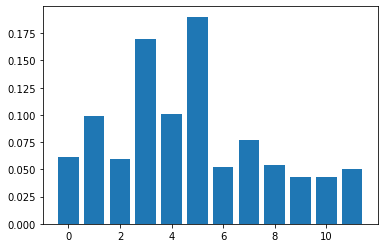

In [136]:
import matplotlib.pyplot as plt 
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [141]:
probs_pred = model.predict_proba(X_test.values)
confidence = 0.86

correct, incorrect, skipped = 0, 0, 0

for arr_prob, actual in zip(probs_pred, y_test.values): 
  prob = arr_prob[np.argmax(arr_prob)]
  pred = np.argmax(arr_prob)

  if prob > confidence: 
    if pred == actual[0]: 
      correct += 1
    else: 
      incorrect += 1
  else: 
    skipped += 1

print(correct / (incorrect + correct))
print(skipped / len(y_test))

0.9087090450854103
0.6374619289340101


## Run 

In [132]:
# create prompt for selecting players
tour_names = {i: loc.inverse_transform([i])[0] for i in X['tourney_name'].unique()}
tour_names = sorted(tour_names.items(), key=lambda x:x[1])

# tournament round 
rounds = {i: round_enc.inverse_transform([i])[0] for i in X['round'].unique()}
rounds = sorted(rounds.items(), key=lambda x:x[1])

# surface
surfaces = {i: surf.inverse_transform([i])[0] for i in X['surface'].unique()}
surfaces = sorted(surfaces.items(), key=lambda x:x[1])

# players
P1 = list(df['W'].unique())
P2 = list(df['W'].unique())
P1.extend(P2)
players = {i: player_id.inverse_transform([i])[0] for i in set(P1)}
players = sorted(players.items(), key=lambda x:x[1])

# hands 
H1 = list(df['winner_hand'].unique())
H2 = list(df['loser_hand'].unique())
H1.extend(H2)
hands = {i: hand_enc.inverse_transform([i])[0] for i in set(H1)}
hands = sorted(hands.items(), key=lambda x:x[1])

### ------PROMPT------

# location
pprint(tour_names)
location_fet = int(input("Tour Name: "))
clear_output()

# round 
pprint(rounds)
round_fet = int(input("Round: "))
clear_output()

# surfaces
pprint(surfaces)
surface_fet = int(input("Surface: "))
clear_output()

# players
pprint(players)
P1 = int(input("Player 1: "))
P2 = int(input("Player 2: "))
clear_output()

# ranks
RankA = int(input("Player 1 Rank: "))
RankB = int(input("Player 2 Rank: "))
RankD = abs(RankA - RankB)
clear_output()

# hand
pprint(hands)
HA = float(input("Player 1 Hand: "))
HB = float(input("Player 2 Hand: "))
clear_output()

# height
HTA = float(input("Player 1 Height: "))
HTB = float(input("Player 2 Height: "))
clear_output()

# predict and return result
X_pred = [location_fet, surface_fet, HA, HTA, HB, HTB, round_fet, RankA, RankB, P1, P2, RankD]
y_pred = model.predict_proba([X_pred])
if np.argmax(y_pred) == 1: 
  print('Over: ', str(np.round(100*y_pred[0][np.argmax(y_pred)], 2)) + '%', f'Minimum Confidence: {86}.00%')
else:  
  print('Under: ', str(np.round(100*y_pred[0][np.argmax(y_pred)], 2)) + '%', f'Minimum Confidence: {86}.00%')

Over:  54.54% Minimum Confidence: 67.00%
